# @Xiufan: Please update the aws-braket-sdk and the qiskit-braket-provider to their latest package version

In [1]:
### To update the packages, just run this command in your terminal please

!pip install amazon-braket-sdk==1.72.2 
!pip install qiskit-braket-provider==0.2.0

  Obtaining dependency information for qiskit-braket-provider==0.2.0 from https://files.pythonhosted.org/packages/c0/84/79ed26a784e75fd830e7094a6e51de8801534b125761006cf8893be4e81b/qiskit_braket_provider-0.2.0-py3-none-any.whl.metadata
  Attempting uninstall: qiskit-braket-provider
    Found existing installation: qiskit-braket-provider 0.1.1
    Uninstalling qiskit-braket-provider-0.1.1:
      Successfully uninstalled qiskit-braket-provider-0.1.1


#### Running a bell circuit on different backends

In [2]:
import numpy as np
import time

from braket.circuits import Circuit
from qiskit_braket_provider import AWSBraketProvider
from braket.aws import AwsSession

from qiskit import QuantumCircuit
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.primitives import BackendEstimator

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# TODO: Please adjust the S3 bucket to one of yours

In [3]:
aws_session = AwsSession(default_bucket="xiufan-bucket-prgroup") # TODO: Please replace with your S3 bucket

In [4]:
batchsize = 50
n_shots = 10_000

#### Run with native Braket SV Backend

In [5]:
backend = AWSBraketProvider().get_backend('SV1')

device = backend._device
device

C:\Users\fff\AppData\Local\Temp\ipykernel_24476\291348685.py:1: DeprecationWarning: AWSBraketProvider is deprecated. Use BraketProvider instead
  backend = AWSBraketProvider().get_backend('SV1')


Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)

In [6]:
braket_bell_circ = Circuit().h(0).cnot(0, 1)
print(braket_bell_circ)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


In [7]:
start_time = time.time()
job_braket_native = device.run_batch(
    [braket_bell_circ] * batchsize,
    shots=n_shots,
)
run_batch_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_batch_time, 2)))
print('Execution time per circuit:', round(run_batch_time / batchsize, 2), 'seconds')

--- 26.12 seconds ---
Execution time per circuit: 0.52 seconds


#### Run with Braket Provider + **Estimator Primitive**

D:\Anaconda\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


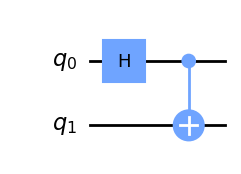

In [8]:
qiskit_bell_circ = QuantumCircuit(2)
qiskit_bell_circ.h(0)
qiskit_bell_circ.cx(0, 1)

qiskit_bell_circ.draw("mpl")

Formerly took 532 secs to complete

In [9]:
backend = AWSBraketProvider().get_backend('SV1')
estimator = BackendEstimator(backend)
qiskit_observables = SparsePauliOp.from_list(([('XX', 0.25), ("IZ", 0.25), ("ZZ", 0.25), ("XY", 0.25)]))

qiskit_start_time = time.time()
job = estimator.run(
    circuits=[qiskit_bell_circ] * batchsize,
    observables=[qiskit_observables] * batchsize,
    shots=n_shots
)
job.result().values # This is the time-consuming line

qiskit_run_batch_time = time.time() - qiskit_start_time
print('--- {} seconds ---'.format(round(qiskit_run_batch_time, 2)))
print('Execution time per circuit:', round(qiskit_run_batch_time / (batchsize * 3), 2), 'seconds')

C:\Users\fff\AppData\Local\Temp\ipykernel_24476\1479952175.py:1: DeprecationWarning: AWSBraketProvider is deprecated. Use BraketProvider instead
  backend = AWSBraketProvider().get_backend('SV1')


--- 95.29 seconds ---
Execution time per circuit: 0.64 seconds


In [10]:
qiskit_expvals = job.result().values

#### Use ``Estimator`` from Qiskit

In [11]:
start_time = time.time()
job = Estimator().run(
    circuits=[qiskit_bell_circ] * batchsize,
    observables=[qiskit_observables] * batchsize,
    shots=n_shots
)
qiskit_expvals_2 = job.result().values
run_batch_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_batch_time, 2)))
# Three non-commuting parts of the Hamiltonian lead to three measured circuits per Hamiltonian
print('Execution time per circuit:', round(run_batch_time / (batchsize * 3), 2), 'seconds')

--- 0.04 seconds ---
Execution time per circuit: 0.0 seconds


In [12]:
qiskit_expvals_2 - qiskit_expvals

array([ 1.26742539e-03, -3.17297782e-03, -5.39735636e-03, -6.12383169e-04,
       -4.88840002e-03, -7.53573607e-03,  2.07906252e-03,  2.68320866e-03,
       -5.83506741e-03, -5.54646183e-03, -7.55372217e-03,  3.29949109e-04,
        2.80148113e-05, -6.12798165e-04,  3.69972297e-03, -1.89050051e-03,
       -1.41142394e-04, -2.64539540e-03, -5.86278540e-03,  7.20523381e-03,
       -2.48811241e-03, -8.01026307e-03,  4.48681254e-03,  1.67035149e-03,
       -8.59625698e-03,  3.81494831e-03,  4.22405187e-03, -8.96805555e-04,
       -1.81884844e-03,  3.30777625e-03, -1.68051868e-03, -5.77328151e-03,
        1.29633280e-03, -1.79323888e-03,  6.44592058e-03, -4.41538982e-03,
       -2.44238571e-03, -3.12494847e-03,  8.53483258e-03, -4.02757647e-03,
       -7.66495925e-03,  4.31504371e-03, -7.95393410e-03,  3.77400986e-03,
       -1.59349799e-03, -1.99855226e-03,  3.75958220e-03,  9.43444432e-03,
       -3.79575942e-03,  8.83064266e-04])

In [13]:
max(qiskit_expvals_2 - qiskit_expvals)

0.009434444322264202

#### Running batch of qiskit circuits with SV1 backend provider

In [14]:
backend = AWSBraketProvider().get_backend('SV1')

C:\Users\fff\AppData\Local\Temp\ipykernel_24476\167129986.py:1: DeprecationWarning: AWSBraketProvider is deprecated. Use BraketProvider instead
  backend = AWSBraketProvider().get_backend('SV1')


In [15]:
qiskit_start_time = time.time()
job = backend.run(
    [qiskit_bell_circ] * batchsize,
    shots=n_shots
)
result = job.result() # This is the time-consuming line

qiskit_run_batch_time = time.time() - qiskit_start_time
print('--- {} seconds ---'.format(round(qiskit_run_batch_time, 2)))
print('Execution time per batch:', round(qiskit_run_batch_time / batchsize, 2), 'seconds')

--- 33.94 seconds ---
Execution time per batch: 0.68 seconds
